Bias detection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import re
import spacy
import nltk
from nltk.tokenize import sent_tokenize

In [2]:
from transformers import pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

c:\Users\17336\.conda\envs\CS--178\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [3]:
def get_entity_specific_sentiment_transformer(text, entity, char_limit=1500):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    for sent in sentences:
        if entity.lower() in sent.lower():
            short_sent = sent[:char_limit]  # Truncate to avoid token overflow
            result = sentiment_pipeline(short_sent)[0]
            label = result['label']
            score = result['score']
            return score if label == 'POSITIVE' else -score
    return 0.0


In [4]:
df = pd.read_csv(r"C:\Users\17336\CS-178\cs178-final-VAST2021\data\news_articles.csv", delimiter="|", engine="python")
df = df.dropna(subset=["content", "source"])  # Drop rows without content or source

In [5]:
# Function to clean misinterpreted characters from the DataFrame
def clean_misinterpreted_characters(df):
    return df.applymap(
        lambda x: ''.join(c for c in str(x) if ord(c) < 128 and c.isprintable()) if isinstance(x, str) else x
    )

# Clean the DataFrame
df = clean_misinterpreted_characters(df)

C:\Users\17336\AppData\Local\Temp\ipykernel_10700\1607328741.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


In [6]:
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity  # Range: [-1, 1]

df["sentiment"] = df["content"].apply(get_sentiment)

In [7]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

# 1. White-list ORG + correct labels
CORRECT_LABELS = {
    "kronos": "ORG",
    "gastech": "ORG",
    "pok": "ORG",
    "apa": "ORG",
    "anti-pollution alliance": "ORG",
    "protectors of kronos": "ORG",
    "kronos government": "ORG"
}

# 2. Special normalization mapping
SPECIAL_CASES = {
    "people of kronos": "pok",
    "the people of kronos": "pok",
    "protectors of kronos": "pok",
    "citizens of kronos": "pok",
    "members of kronos": "pok"
}

PERSON_NORMALIZATION = {
    "carman d'": "carman adrien",
    "carman de adrien": "carman adrien",
    "carmen adrien": "carman adrien",
    "ada campo-corren": "ada campo-corrente",
    "sanjorge jr.": "sanjorge jr",
    "sanjorge jr.'s": "sanjorge jr",
    "sanjorge, jr.": "sanjorge jr",
    "sanjorge sr.": "sanjorge sr",
    "silvia marek's": "silvia marek",
    "sten": "sten sanjorge jr",
    "sten jr.": "sten sanjorge jr",
    "sten sanjorge": "sten sanjorge jr",
    "sten sanjorge jr": "sten sanjorge jr",
    "sten sanjorge jr.": "sten sanjorge jr",
    "sten sanjorge jr.'s": "sten sanjorge jr",
    "sten sanjorge - perforating": "sten sanjorge jr",
    "sten sanjorge de gastech": "sten sanjorge jr",
    "sten sanjorge je": "sten sanjorge jr",
    "sten sanjorge jr. sanjorge": "sten sanjorge jr",
    "sten sanjorge pok": "sten sanjorge jr",
    "sten sanjorge, jr": "sten sanjorge jr",
    "sten sanjorge, jr.": "sten sanjorge jr"
}

ENTITY_BLACKLIST = {"considerar"}

# 3. Clean entity name
def clean_entity_name(name):
    if not name:
        return ""
    name = name.strip()
    name = name.replace("抯", "'s")
    name = name.replace("揓", "J")
    name = name.replace("�", "")
    name = "".join(c for c in name if ord(c) < 128)  # Keep ASCII only
    name = ''.join(c for c in name if c.isprintable())
    return name

# 4. Label correction + name cleaning
def correct_label(ent):
    text = clean_entity_name(ent.text.strip())
    text_lower = text.lower()

    if text_lower in ENTITY_BLACKLIST:
        return None

    for pattern, normalized_name in SPECIAL_CASES.items():
        if pattern in text_lower:
            return {"text": normalized_name, "label": "ORG"}
        
    if text_lower in CORRECT_LABELS:
        return {"text": text, "label": CORRECT_LABELS[text_lower]}
    
    elif ent.label_ == "PERSON":
        normalized = PERSON_NORMALIZATION.get(text_lower, text_lower)
        return {"text": normalized, "label": "PERSON"}
    
    else:
        return None
    
def extract_entities_cleaned(text):
    # Remove text inside <<...>> using regex
    text = re.sub(r"<<.*?>>", "", text)

    # Clean the text to remove misinterpreted characters
    text = text.encode("ascii", "ignore").decode("ascii")  # Remove non-ASCII characters
    text = ''.join(c for c in text if c.isprintable())  # Remove non-printable characters
    
    doc = nlp(str(text))  # Process the cleaned text with spaCy
    ents = []
    seen = set()
    for ent in doc.ents:
        ent_info = correct_label(ent)
        if ent_info:
            # Normalize entity text to lowercase
            normalized_text = ent_info["text"].lower()
            key = (normalized_text, ent_info["label"])
            if key not in seen:
                ents.append(normalized_text)
                seen.add(key)
    return ents

# Apply to DataFrame
df["entities"] = df["content"].apply(extract_entities_cleaned)

In [13]:
df["entities"]

0                                     [pok, kronos, van]
1                                 [silvia marek, kronos]
2                    [luis araullo, kronos, tomas sarto]
3      [kronos, pok, sten sanjorge jr, gastech, sten ...
4                                 [kronos, henk bodrogi]
                             ...                        
840    [cesare nespola, nespola, araullo, kapelou, vi...
841                                       [kapelou, pok]
842    [kronos, gastech, carman adrien, elian karel, ...
843    [kronos, elian karel, karel, michale kraft, ca...
844                                                   []
Name: entities, Length: 845, dtype: object

In [9]:
df["content"]

0      Fifteen members of the Protectors of Kronos (P...
1      Silvia Marek, leader of the Protectors of Kron...
2      In a glitzy press conference late last year Pr...
3      NOTE: This article is the first in a series, r...
4      NOTE: This article is the last installment of ...
                             ...                        
840    It is with great pain that we announce the dea...
841    In a press release today today, President Kape...
842    Dozen protesters being present guards of gathe...
843    The police force of Kronos stopped Elian Karel...
844    The members of POK held a great demonstration ...
Name: content, Length: 845, dtype: object

In [8]:
df_expanded = df.explode("entities")
df_expanded = df_expanded.dropna(subset=["entities"])

In [9]:
df_expanded["entity_sentiment"] = df_expanded.apply(
    lambda row: get_entity_specific_sentiment_transformer(row["content"], row["entities"]) if row["entities"] else 0,
    axis=1
)

In [10]:
df_expanded.to_csv("df_expanded_with_sentiment.csv", index=False)

In [ ]:
df_expanded = pd.read_csv("/mnt/data/df_expanded_with_sentiment.csv")

c:\Users\17336\.conda\envs\CS--178\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 25251 (\N{CJK UNIFIED IDEOGRAPH-62A3}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\17336\.conda\envs\CS--178\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25251 (\N{CJK UNIFIED IDEOGRAPH-62A3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


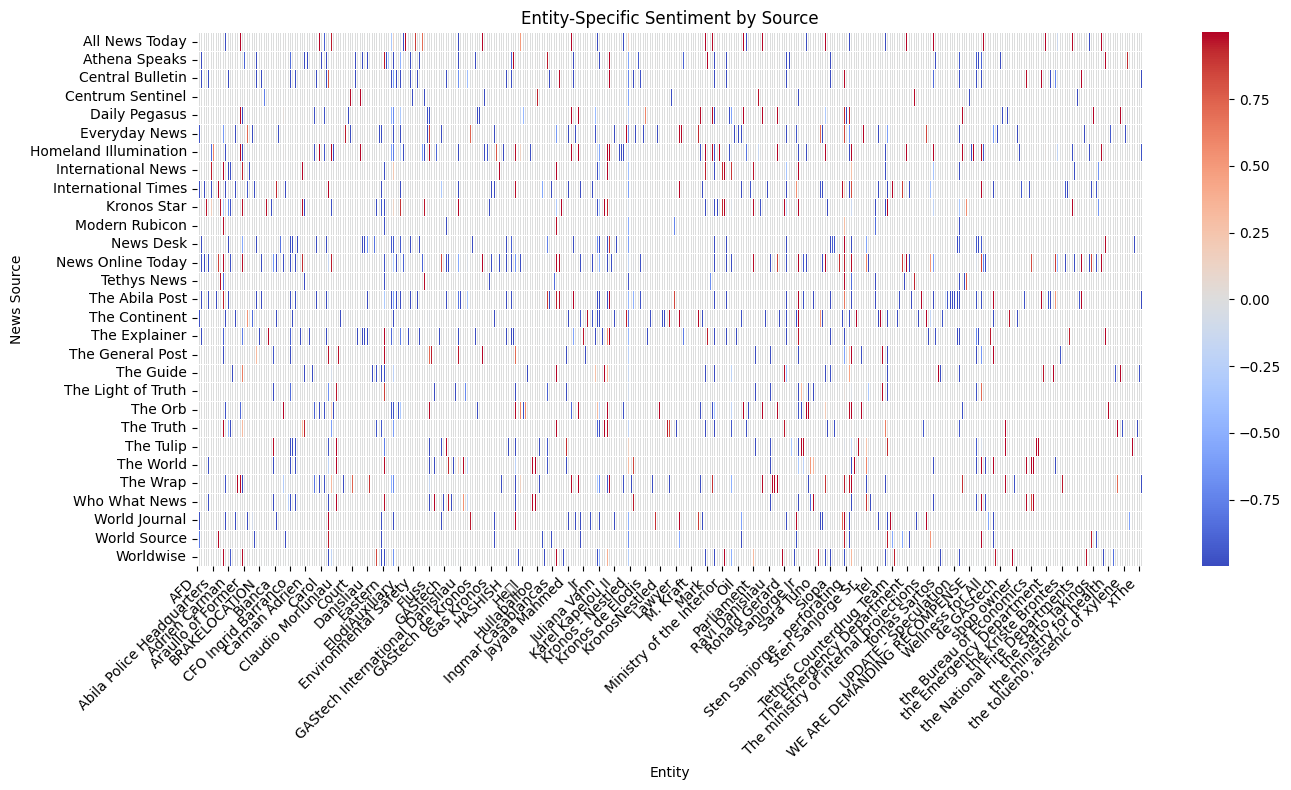

In [14]:
heatmap_data = df_expanded.pivot_table(
    index="source",
    columns="entities",
    values="entity_sentiment",
    aggfunc="mean"
).fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0, annot=False, linewidths=0.5)
plt.title("Entity-Specific Sentiment by Source")
plt.xlabel("Entity")
plt.ylabel("News Source")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(pivot)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(pca_coords)

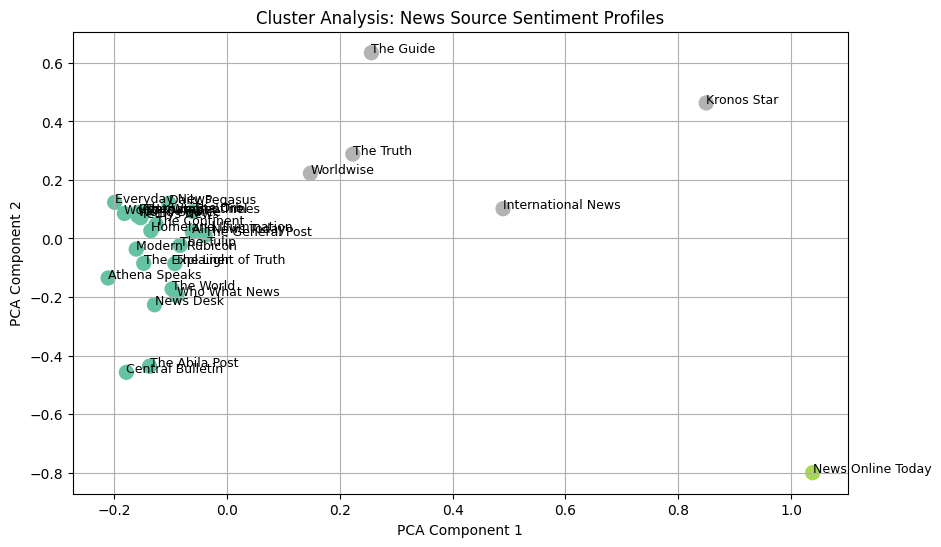

In [41]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=labels, cmap="Set2", s=100)

for i, txt in enumerate(pivot.index):
    plt.annotate(txt, (pca_coords[i, 0], pca_coords[i, 1]), fontsize=9)

plt.title("Cluster Analysis: News Source Sentiment Profiles")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

In [44]:
top_pos = df[df["sentiment"] > 0.5][["source", "content", "sentiment"]].head(3)
top_neg = df[df["sentiment"] < -0.2][["source", "content", "sentiment"]].head(3)


In [45]:
print("\nPositive Sentiment Samples:")
print(top_pos.to_string(index=False))

print("\nNegative Sentiment Samples:")
print(top_neg.to_string(index=False))


Positive Sentiment Samples:
           source                                                                                                                                                                                                                                                                             content  sentiment
News Online Today Protesters aligned with the Protectors of Kronos (POK) activist group surrounded government buildings chanting and carry images of their so-called martyrs. Kronos government security forces in concert with Abila police suppressed the protest with an impressive show of force.        1.0

Negative Sentiment Samples:
          source                                                                                                                                                                                                                                                                                                                            